### 1.1 Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from torchvision.models import resnet50, vgg16_bn, vgg19_bn

### 1.2 Set Device to cuda

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 1.3 Download Fashion MNIST Dataset

In [3]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True)
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
print(train_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train


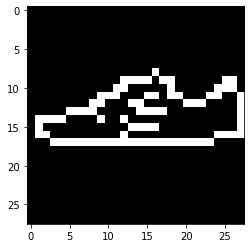

In [5]:
image, label= train_set[np.random.randint(1,60000)][0], train_set[579][1]
image = np.array(image)
image = cv2.Canny(image,100,200)
plt.imshow(image, cmap= 'gray')
print((train_set))

### Custom Transform Function for applying Canny Edge Detector

In [6]:
class ToEdge(object):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    Converts a PIL Image or numpy.ndarray (H x W x C) in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1)
    or if the numpy.ndarray has dtype = np.uint8
    In the other cases, tensors are returned without scaling.
    """

    def __call__(self, pic):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        image = np.array(pic)
        image = cv2.Canny(image,0.7,1.4)
        #image = torch.from_numpy(image)
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        return image

    def __repr__(self):
        return self.__class__.__name__ + '()'

### Convert to Tensor

In [7]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True,transform=
                                               transforms.Compose([ToEdge(),transforms.ToTensor(),transforms.Resize((64,64))]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([ToEdge(),transforms.ToTensor(),transforms.Resize((64,64))]))

In [8]:
print(train_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToEdge()
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
           )


### 1.4 Visualize a sample Image

In [9]:
img_tensor, label = test_set[np.random.randint(1,10000)]
print(img_tensor.shape, label)
#plt.imshow(img_tensor.squeeze(),cmap='gray');
type(img_tensor)
print(torch.min(img_tensor))

torch.Size([3, 64, 64]) 0
tensor(0.)


### 1.4 Load Data into Batches

In [10]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size)

### 1.5 Assign Output Labels to Numbers for Classification

In [11]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

### 1.6 Construction of CNN

### 1.7 Calling The Model CNN

### 1.8 Testing the data on the Model

### VGG16 Classifier

In [12]:
class VGG16Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = vgg16_bn(pretrained=True)
        n_features = self.nn.classifier[6].in_features
        
        # Remove final layer
        final_features = list(self.nn.classifier.children())[:-1]
        final_features.extend([nn.Linear(n_features, 10)])
        
        # do not allow backpropagation through
        # pre-trained model layers
        for param in self.nn.parameters():
            param.requires_grad = False
        
        self.nn.classifier = nn.Sequential(*final_features)
    
    def forward(self, x):
        return self.nn(x)

In [13]:
model = VGG16Classifier()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG16Classifier(
  (nn): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0,

In [14]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images)
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
        
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images)
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
        

Iteration: 500, Loss: 1.2364740371704102, Accuracy: 61.62999725341797%
Iteration: 1000, Loss: 0.9530223608016968, Accuracy: 62.5%
Iteration: 1500, Loss: 1.4569872617721558, Accuracy: 62.959999084472656%
Iteration: 2000, Loss: 0.9390971660614014, Accuracy: 62.53999710083008%
Iteration: 2500, Loss: 1.2273359298706055, Accuracy: 62.40999984741211%
Iteration: 3000, Loss: 1.0973656177520752, Accuracy: 62.40999984741211%


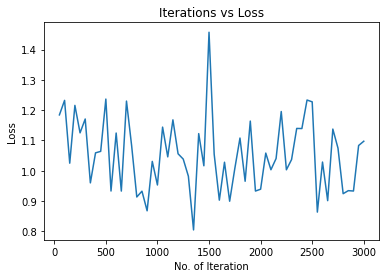

In [15]:
import torch
loss_list_1= torch.tensor(loss_list, device = 'cpu')
iteration_list_1 = torch.tensor(iteration_list, device = 'cpu')
plt.plot(iteration_list_1, loss_list_1)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

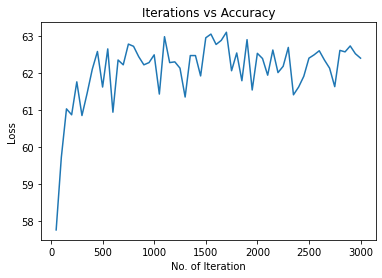

In [16]:
import torch
accuracy_list_1= torch.tensor(accuracy_list, device = 'cpu')
#iteration_list_1 = torch.tensor(iteration_list, device = 'cpu')
plt.plot(iteration_list_1, accuracy_list_1)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Accuracy")
plt.show()

In [17]:
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of T-shirt/Top: 59.10%
Accuracy of Trouser: 82.90%
Accuracy of Pullover: 65.90%
Accuracy of Dress: 67.80%
Accuracy of Coat: 34.50%
Accuracy of Sandal: 64.70%
Accuracy of Shirt: 28.20%
Accuracy of Sneaker: 74.40%
Accuracy of Bag: 70.00%
Accuracy of Ankle Boot: 78.30%


In [18]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [19]:
import sklearn.metrics as metrics

confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.54      0.54      0.54     60000
           1       0.87      0.85      0.86     60000
           2       0.55      0.57      0.56     60000
           3       0.58      0.63      0.61     60000
           4       0.45      0.44      0.45     60000
           5       0.67      0.62      0.65     60000
           6       0.39      0.35      0.37     60000
           7       0.72      0.74      0.73     60000
           8       0.69      0.71      0.70     60000
           9       0.71      0.76      0.74     60000

    accuracy                           0.62    600000
   macro avg       0.62      0.62      0.62    600000
weighted avg       0.62      0.62      0.62    600000


